# Outliers detection: 2D application

This notebook will be tested on Solar dataset.

#### References:
- ["Comparing anomaly detection algorithms for outlier detection on toy datasets"](http://scikit-learn.org/dev/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py).

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
from datasets import solar
from tools.reader import get_dcol
import numpy as np, pandas as pd
import seaborn as sns
sns.set(style="white", color_codes=True)
from scipy import stats

### functions

In [2]:
## plot outliers detection results
def plot_outliers(X:'array', clf:'scikit estimator',title:str = '', outliers_fraction:float = 0.25):
    import matplotlib.pyplot as plt
    
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100), np.linspace(np.min(X[:,1]), np.max(X[:,1]), 100))
        
    import time
    t0 = time.time()
    
    #try:
    #    y_pred = clf.fit(X).predict(X)
    #except:
    #    y_pred = clf.fit_predict(X)

    try:
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    except:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    threshold = stats.scoreatpercentile(scores_pred,
                                        100 * outliers_fraction)

        
    t1 = time.time()
    
    
    try:
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    except:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
     
    
    subplot = plt.subplot()
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                     cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                        linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                     colors='orange')

    colors = np.array(['yellow', 'black'])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])  
 
    
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plt.xlabel('v1')
    plt.ylabel('v2')
    plt.title(title, fontsize = 14)
    plt.show()

### load data

In [3]:
# load data
data, dcol = solar.load()
# select columns
data = data[['hour','DSWRF267', 'y']]
data.rename(columns = {'DSWRF267' : 'v1', 'y' : 'v2'}, inplace = True)
# clean
del(dcol)
# display info
data.info()

Load data..
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26029 entries, 2013-01-01 10:00:00 to 2015-12-31 23:00:00
Data columns (total 3 columns):
hour    26029 non-null int64
v1      26029 non-null float64
v2      26029 non-null float64
dtypes: float64(2), int64(1)
memory usage: 813.4 KB


#### per hour

In [4]:
# select rows
hour = 11
idata = data[data.hour==hour]
idata.drop('hour', axis = 1, inplace = True)
# data preparation
X = idata[['v1','v2']].values

### display data

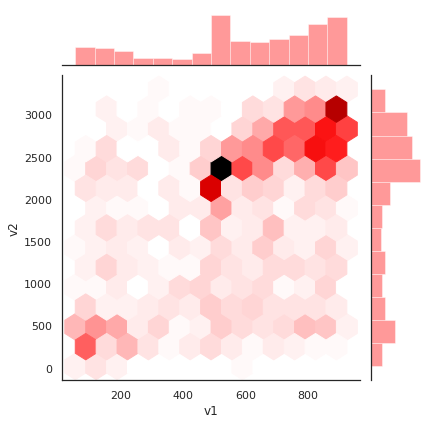

In [5]:
g = sns.jointplot(x="v1", y="v2", data=idata, kind = 'hex', color = 'red')

### Robust covariance

[covariance.EllipticEnvelope](http://scikit-learn.org/dev/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope):This one assumes the data is Gaussian and learns an ellipse. It thus degrades when the data is not unimodal. Notice however that this estimator is robust to outliers.

In [6]:
from sklearn.covariance import EllipticEnvelope
outliers_fraction = 0.25
clf = EllipticEnvelope(contamination=outliers_fraction, support_fraction = None, assume_centered = True)

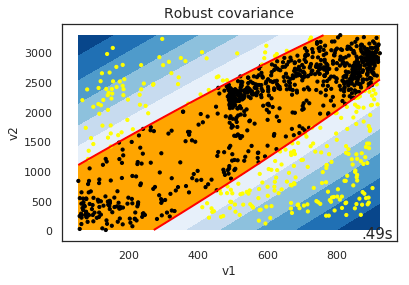

In [7]:
plot_outliers(X, clf,title = 'Robust covariance', outliers_fraction = outliers_fraction)

### One-Class SVM:

[svm.OneClassSVM](http://scikit-learn.org/dev/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM): it is known to be sensitive to outliers and thus does not perform very well for outlier detection. This estimator is best suited for novelty detection when the training set is not contaminated by outliers. That said, outlier detection in high-dimension, or without any assumptions on the distribution of the inlying data is very challenging, and a One-class SVM might give useful results in these situations depending on the value of its hyperparameters.

In [8]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
gamma = 0.25
estimator = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",gamma=gamma)
clf = Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', estimator),
        ])

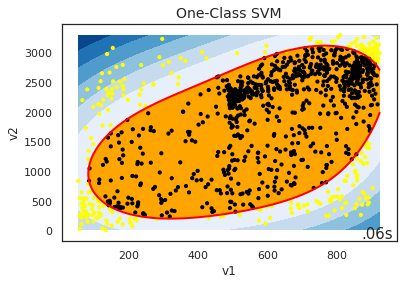

In [9]:
plot_outliers(X, clf,title = 'One-Class SVM')

### Isolation Forest:

[ensemble.IsolationForest](http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest): it seem to perform reasonably well for multi-modal data sets. 

In [10]:
from sklearn.ensemble import IsolationForest
outliers_fraction = 0.3
clf = IsolationForest(
    n_estimators = 100,
    max_samples = 'auto',
    max_features = 1.,
    bootstrap = False,
    #behaviour='new',
    contamination=outliers_fraction,
    random_state=42,
    n_jobs = -1
)

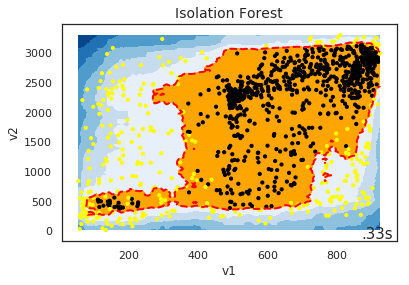

In [11]:
plot_outliers(X, clf,title = 'Isolation Forest')

### Local Outlier Factor:

[neighbors.LocalOutlierFactor](http://scikit-learn.org/dev/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor): it seem to perform reasonably well for multi-modal data sets. The advantage of neighbors.LocalOutlierFactor is shown for the third data set, where the two modes have different densities.

In [12]:
from sklearn.neighbors import LocalOutlierFactor
outliers_fraction = 0.25
clf = LocalOutlierFactor(
        n_neighbors=25, contamination=outliers_fraction)

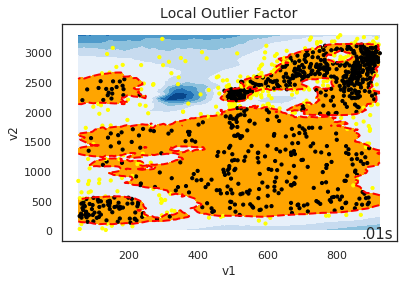

In [13]:
plot_outliers(X, clf,title = 'Local Outlier Factor')

## Median Absolute Deviation of RESIDUES:

[info] threshold = 2.3 / num. outliers(total) = 211(1085) / percent of filtered data: 19.447 % / r2 score = 0.718


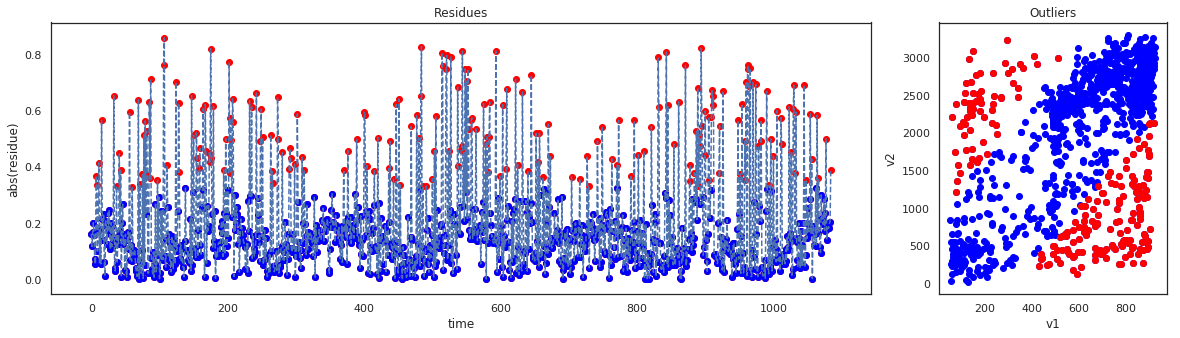

In [14]:
from preprocessing.outliers import median2D

# loop of hours
for ihour in range(24)[:1]:
    ihour = 11
    idata = data[data.hour==ihour]
    idata.drop('hour', axis = 1, inplace = True)
    # data preparation
    X = idata[['v1','v2']].values    
    isoutlier = median2D.launch(X[:,0], X[:,1], percent=20., isplot=True)
 

### 2D-Gaussian: 

[info] Number of datapoints: 1085
[info] Number of dimensions/features: 2
[info] Threshold = 0.4
[info] Number of Outliers = 214 (19.724%)


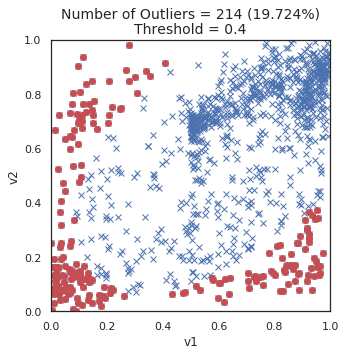

In [24]:
from preprocessing.outliers import multigaussian as ms

# loop of hours
for ihour in range(24)[:1]:
    ihour = 11
    idata = data[data.hour==ihour]
    idata.drop('hour', axis = 1, inplace = True)
    # data preparation
    X = idata[['v1','v2']].values    
    threshold = .4
    X_filtered, dinfo = ms.launch_array(X, threshold, isdeep=True)